201920915 박영빈 기계학습 중간대체과제 클러스터링

커널: 파이썬 3.10.13

목표: 데이터의 성별, 연령대, 직업 유형, 이용금액에 따라 집단으로 나누어 소비 분석       
     이용금액대에 따라 연령대나 직업 유형이 다르게 묶일 것으로 기대됩니다. 

데이터: 인천광역시 소비데이터     

-- 데이터 출처       
https://www.data.go.kr/data/15076578/fileData.do         

-- 내용            
인천광역시 행정구별 소비데이터로 성별 / 10세단위 연령별 / 직업별 / 소득분위별 금융데이터        

-- 정보             
* 인구단위: 명 / 금액단위: 천원      
* 성별 [0:전체 1:남성 2:여성]       
* 직업구분 [0:전체 1:자영업자 2:급여소득자(상장) 3:급여소득자(비상장) 4:비경제활동인구]     
* 최근 12개월신용 및 체크카드이용 금액합계[최근12개월 전체 신용카드  및 체크카드의 신용판매 이용금액 합계(현금서비스 제외)// 단위: 천원]        
* 최근 12개월 전체체크카드 이용금액합계[최근12개월 전체 체크카드 이용금액  합계// 단위: 천원]       
* 최근 12개월 해외이용금액합계[최근12개월 전체 신용카드 해외  신용판매 이용금액 합계(현금서비스 제외)// 단위: 천원]     
* 최근 12개월 평균신용  및 체크카드이용 금액합계[최근12개월 (신용카드+체크카드)  이용금액 >0 인 인구의 (신용카드+체크카드) 신용판매 이용금액 평균(현금서비스 제외)// 단위: 천원]        





In [1]:
# 필요한 모듈을 설치하고 임포트하기

%pip install factor_analyzer

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
%matplotlib inline
 
from factor_analyzer import FactorAnalyzer

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

Note: you may need to restart the kernel to use updated packages.


In [2]:
# pandas 모듈을 통해 csv파일을 읽기
data18 = pd.read_csv("./2018.csv", encoding="utf-8")
data19 = pd.read_csv("./2019.csv", encoding="utf-8")
data20 = pd.read_csv("./2020.csv", encoding="utf-8")

# 데이터 하나로 합치기
df = pd.concat([data18, data19, data20])

In [3]:
# 데이터 칼럼 확인
print(df.columns)

# 데이터 확인
print(df.loc[14773:14780,])
print(len(df))

Index(['기준년월', '행정동코드', '시도명', '시군구명', '성별', '연령별', '직업구분', '분위구분',
       '최근12개월신용및체크카드이용금액합계', '최근12개월전체체크카드이용금액합계', '최근12개월해외이용금액합계',
       '최근12개월평균신용및체크카드이용금액합계', '최근12개월평균체크카드이용금액', '최근12개월평균해외이용금액',
       '최근12개월신용및체크카드이용인구수', '최근12개월체크카드이용인구수', '최근12개월해외이용인구수',
       '최근1개월신용및체크카드이용금액합계', '최근1개월체크카드이용금액합계', '최근1개월해외신판이용금액합계',
       '최근1개월평균신용및체크카드이용금액', '최근1개월평균체크카드이용금액', '최근1개월평균해외이용금액',
       '최근1개월신용및체크카드이용인구수', '최근1개월체크카드이용인구수', '최근1개월해외이용인구수'],
      dtype='object')
             기준년월       행정동코드    시도명 시군구명  성별  연령별  직업구분  분위구분  \
14773  2019-06-30  2826000000  인천광역시   서구   2   30     4     0   
14774  2019-06-30  2826000000  인천광역시   서구   2   30     3    10   
14775  2019-06-30  2826000000  인천광역시   서구   2   40     0     5   
14776  2019-06-30  2826000000  인천광역시   서구   2   40     2     7   
14777  2019-06-30  2826000000  인천광역시   서구   2   40     3    10   
14778  2019-06-30  2826000000  인천광역시   서구   2   40     1     4   
14779  2019-06-30  2826000000  인천광역시   서구   2   

26개의 칼럼 중 필요없는 것을 제외하고 사용할 칼럼을 선택해 골라야 합니다.        
성별, 연령, 직업구분, 최근12개월신용및체크카드이용금액합계, 최근12개월전체체크카드이용금액합계, 최근12개월해외이용금액합계 총 6개의 칼럼으로 클러스터링을 해보겠습니다.     

In [4]:
# 사용할 데이터 고르기
df = df.loc[:, ['성별', '연령별', '직업구분', '최근12개월신용및체크카드이용금액합계', '최근12개월전체체크카드이용금액합계', '최근12개월해외이용금액합계']]

# 확인
print(df)
print(df[df['연령별'] == 0])

       성별  연령별  직업구분  최근12개월신용및체크카드이용금액합계  최근12개월전체체크카드이용금액합계  최근12개월해외이용금액합계
0       0    0     0         3.795130e+08         146870868.0       2763338.0
1       0    0     1         4.728643e+07           7819321.0        471898.0
2       0    0     3         2.186959e+09         446679226.0      33492658.0
3       0    0     4         3.206030e+08          95833445.0       2849785.0
4       0   15     1                  NaN                 NaN             NaN
...    ..  ...   ...                  ...                 ...             ...
14728   0   20     1         6.501804e+06           1470820.0        441667.0
14729   1   50     4         2.876060e+07          10222676.0        138121.0
14730   2    0     0         3.732194e+08          67351271.0       3701625.0
14731   2   30     1         1.280765e+07           1740512.0        581868.0
14732   0   80     3         3.963190e+05             38416.0             NaN

[44112 rows x 6 columns]
       성별  연령별  직업구분  최근12개월신용및체크카드이용금

NaN 결측치가 존재하므로 해결해주어야 합니다.        

In [5]:
# 결측치 갯수 확인
df.isnull().sum()

# 연령별은 결측치가 0으로 들어가 있어 나오지 않는다

성별                         0
연령별                        0
직업구분                       0
최근12개월신용및체크카드이용금액합계     6612
최근12개월전체체크카드이용금액합계      6689
최근12개월해외이용금액합계         10566
dtype: int64

연령별은 결측치가 0으로 되어있어 카운팅이 되지 않습니다.       
이용금액합계에서 많은 결측치가 존재합니다.       
이들을 처리해 주어야 합니다.

In [6]:
# 연령은 평균으로 가정하고 바꾸어 주겠습니다.
print(df['연령별'].mean()) # 약 40대
df.loc[df['연령별'] == 0, '연령별'] = 40

# 해외이용금액합계는 없었다고 가정하고 0으로 바꾸어 주겠습니다.
df.loc[df['최근12개월해외이용금액합계'] != df['최근12개월해외이용금액합계'], '최근12개월해외이용금액합계'] = 0

# 최근12개월신용및체크카드이용금액합계, 최근12개월전체체크카드이용금액합계 이 둘이 결측치 인경우 삭제해 주겠습니다.
df = df.dropna()

# 확인
print('결측치 처리후 행의 수:', len(df))
print(df)
print(df[df['연령별'] == 0])

40.126042800145086
결측치 처리후 행의 수: 37423
       성별  연령별  직업구분  최근12개월신용및체크카드이용금액합계  최근12개월전체체크카드이용금액합계  최근12개월해외이용금액합계
0       0   40     0         3.795130e+08         146870868.0       2763338.0
1       0   40     1         4.728643e+07           7819321.0        471898.0
2       0   40     3         2.186959e+09         446679226.0      33492658.0
3       0   40     4         3.206030e+08          95833445.0       2849785.0
6       0   20     0         8.580569e+07          35640370.0       1595063.0
...    ..  ...   ...                  ...                 ...             ...
14728   0   20     1         6.501804e+06           1470820.0        441667.0
14729   1   50     4         2.876060e+07          10222676.0        138121.0
14730   2   40     0         3.732194e+08          67351271.0       3701625.0
14731   2   30     1         1.280765e+07           1740512.0        581868.0
14732   0   80     3         3.963190e+05             38416.0             0.0

[37423 rows x 6 columns]


연령별의 결측치는 40으로 최근12개월해외이용금액합계의 결측치는 이용한적이 없었다고 가정하고 0으로 바꾸어 주었습니다.             
최근12개월신용및체크카드이용금액합계, 최근12개월전체체크카드이용금액합계 이 둘이 결측치 인경우 그 행 자체를 삭제해 주었습니다.          

In [7]:
# 정규화
# from sklearn.preprocessing import StandardScaler
 
# Standard scaler로 평균 0, 표준편차 1로 정규화
# df = pd.DataFrame(StandardScaler().fit_transform(df), columns = df.columns, index = df.index)

# 확인
# print(df)

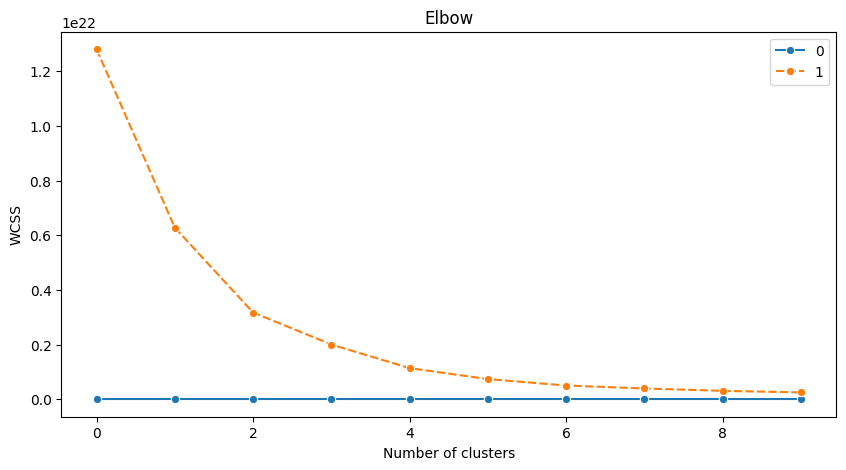

In [8]:
# KMeans 클러스터링은 k개의 집단으로 나누게 되는데 클러스터 내의 총 변동을 설명하는 WCSS(Within Clusters Sum of Squares) 그래프를 이용해 k = 1부터 k = 11까지 중
# elbow method로 WCSS값과 클러스터 K 갯수에 대한 커브선을 그려 뾰족하게 구부러진 부분이나 특정 지점이 팔처럼 굽어지는 부분을 K로 지정하는 방법

from sklearn.cluster import KMeans
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42) # i개의 클러스터로 나누는 알고리즘
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)

# WCSS 그래프 출력
plt.figure(figsize=(10,5))
sns.lineplot(data=(range(1, 11), wcss), marker='o', color='red')
plt.title('Elbow')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

엘보우 메소드에 따라 WCSS 그래프에서 커브가 생기는 지점인 k = 2 를 선택했습니다.

In [9]:
from sklearn.cluster import KMeans

nclusters = 2
seed = 0

# 2개의 집단
km = KMeans(n_clusters=nclusters, random_state=seed)
km.fit(df)

# Predict the cluster for each data point
y_cluster_kmeans = km.predict(df)
y_cluster_kmeans

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

Text(0, 0.5, 'cost')

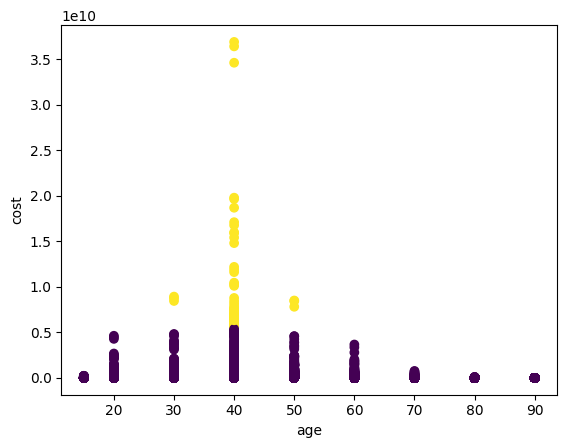

In [10]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 2)
kmeans.fit(df)
labels = kmeans.predict(df)

# 연령과 이용금액 차트
plt.scatter(df['연령별'],df['최근12개월신용및체크카드이용금액합계'], c = labels)
plt.xlabel('age')
plt.ylabel('cost')

x축은 연령별, y축은 최근12개월신용및체크카드이용금액합계            
많은 금액을 소비한 연령대는 40대를 기준으로 분포되어 있습니다.

Text(0, 0.5, 'cost')

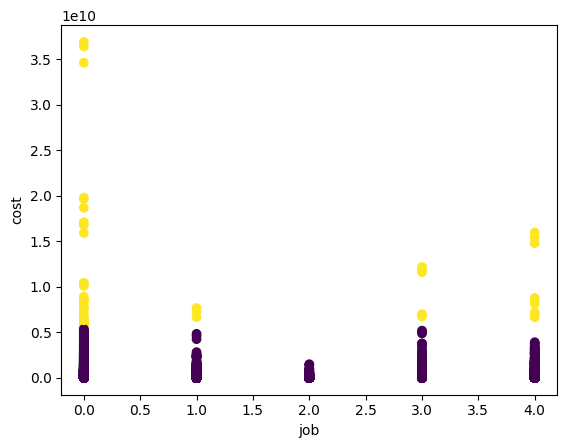

In [11]:
plt.scatter(df['직업구분'],df['최근12개월신용및체크카드이용금액합계'], c = labels)
plt.xlabel('job')
plt.ylabel('cost')

x축은 연령별(0:전체 1:자영업자 2:급여소득자(상장) 3:급여소득자(비상장) 4:비경제활동인구), y축은 최근12개월신용및체크카드이용금액합계


Text(0, 0.5, 'y')

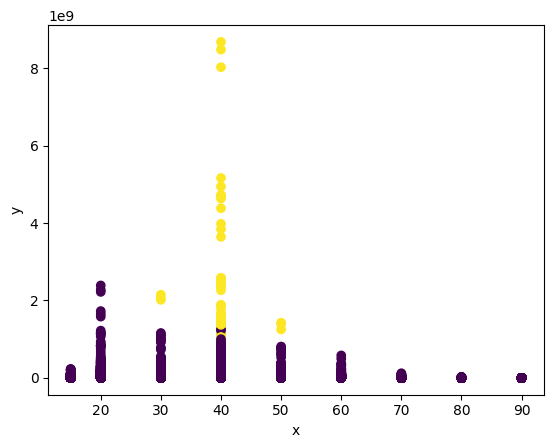

In [12]:
plt.scatter(df['연령별'], df['최근12개월전체체크카드이용금액합계'], c = labels)
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'y')

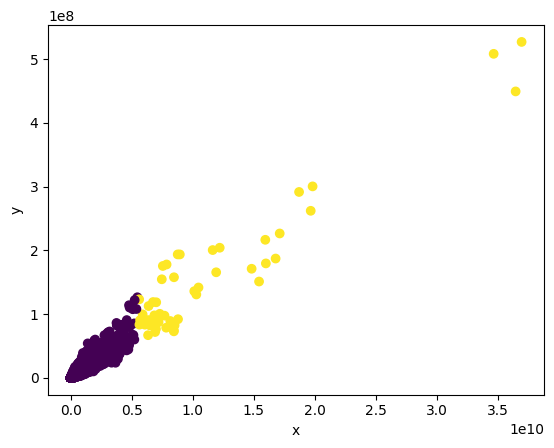

In [13]:
plt.scatter(df['최근12개월신용및체크카드이용금액합계'], df['최근12개월해외이용금액합계'], c = labels)
plt.xlabel('x')
plt.ylabel('y')

x축은 최근12개월신용및체크카드이용금액합계, y축은 최근12개월해외이용금액합계

각 요인에 따라 여러가지 산점도를 보았습니다.        
클러스터링이 단순하게 이용금액대에 따라 많이 이용한 그룹, 이용하지 않은 그룹으로 분류되었습니다.        

In [14]:
from sklearn import metrics
score = metrics.silhouette_score(df, y_cluster_kmeans)
score

0.983156548330547

실루엣 분석은 각 군집 간의 거리가 얼마나 효율적으로 분리 돼있는지를 나타낸다.       
효율적으로 잘 분리 됐다는 것은 다른 군집과의 거리는 떨어져 있고 동일 군집끼리의 데이터는 서로 가깝게 잘 뭉쳐 있다는 의미입니다.     
군집화가 잘 될 수록 개별 군집은 비슷한 정도의 여우 공간을 가지고 떨어져 있을 것입니다.                
실루엣 분석은 실루엣 계수를 기반으로 한다. 실루엣 계수는 개별 데이터가 가지는 군집화 지표입니다.              
개별 데이터가 가지는 실루엣 계수는 해당 데이터가 같은 군집 내의 데이터와 얼마나 가깝게 군집화 돼있고, 다른 군집에 있는 데이터와는 어얼마나 멀리 분리돼 있는지를 나타내는 지표입니다.
실루엣 계수는 -1 에서 1사이의 값을 가지며, 1로 가까워 질수록 근처의 군집과 더 멀리 떨어져 있다는 것이고, 0에 가까울 수록 근처의 군집과 가까워 진다는 것입니다.

0.983156548330547이 나왔으므로 실루엣 점수로는 클러스터링이 잘 이루어졌다고 볼 수 있습니다.

In [15]:
# 정규화
from sklearn.preprocessing import StandardScaler
 
# Standard scaler로 평균 0, 표준편차 1로 정규화
df = pd.DataFrame(StandardScaler().fit_transform(df), columns = df.columns, index = df.index)

# 확인
print(df)

             성별       연령별      직업구분  최근12개월신용및체크카드이용금액합계  최근12개월전체체크카드이용금액합계  \
0     -1.192642 -0.228829 -1.310998             0.504830            0.919032   
1     -1.192642 -0.228829 -0.656854            -0.079171           -0.100534   
2     -1.192642 -0.228829  0.651435             3.682032            3.117315   
3     -1.192642 -0.228829  1.305579             0.401276            0.544811   
6     -1.192642 -1.325025 -1.310998            -0.011460            0.103458   
...         ...       ...       ...                  ...                 ...   
14728 -1.192642 -1.325025 -0.656854            -0.150864           -0.147084   
14729  0.032240  0.319269  1.305579            -0.111736           -0.082912   
14730  1.257122 -0.228829 -1.310998             0.493767            0.335971   
14731  1.257122 -0.776927 -0.656854            -0.139779           -0.145106   
14732 -1.192642  1.963562  0.651435            -0.161596           -0.157586   

       최근12개월해외이용금액합계  
0            0.

이번에는 정규화를 해서 6가지 칼럼을 3가지 요인으로 압축해 클러스터링 해보겠습니다.

0.6602870924389493


<Axes: >

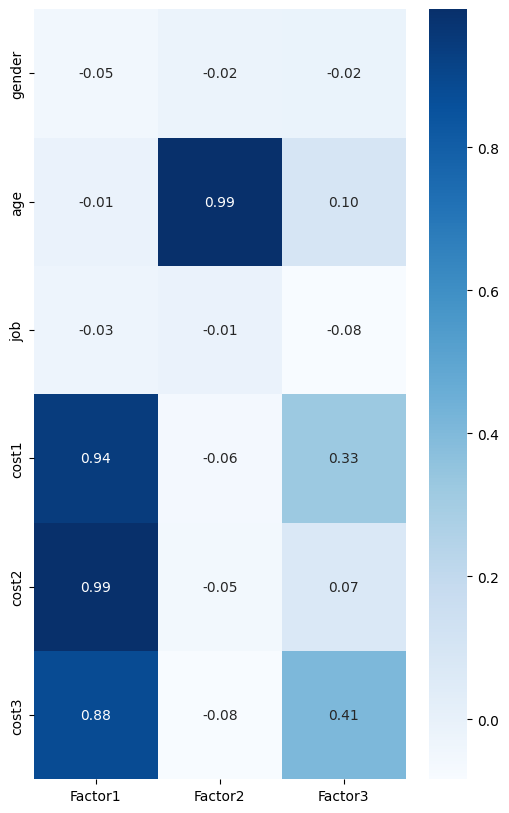

In [16]:
# KMO Test (Kaiser-Meyer-Olkin Test)
# 변수들간 상관관계가 다른 변수에 의해 잘 설명되는 정도를 나타내는 값, 이 값이 작으면 분석을 위한 변수들의 선정이 적절하지 못하다는 것을 의미
# 일반적으로 0.9 이상이면 아주 좋음, 0.8 이상이면 꽤 좋음, 0.7 이상이면 적당함, 0.6 이상이면 평범함, 0.5 미만이면 안 좋음
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all, kmo_model = calculate_kmo(df)
print(kmo_model)
 
# factor 3개로 선택
fa = FactorAnalyzer(n_factors = 3 , rotation = "varimax")
fa.fit(df)
 
# FA: Factor Loadings
fa_result_loading = pd.DataFrame(fa.loadings_, columns = ['Factor1', 'Factor2', 'Factor3'], index=['gender', 'age', 'job', 'cost1', 'cost2', 'cost3'])
 
# 시각화
plt.figure(figsize=(6,10))
sns.heatmap(fa_result_loading, cmap="Blues", annot=True, fmt='.2f') #소수 둘째자리까지

3개의 요인으로 압축할 때 이용금액끼리 매우 높은 상관관계를 보입니다.          
최근12개월신용및체크카드이용금액합계와 최근12개월해외이용금액합계도 어느 정도 상관관계를 보이고 있습니다.       

KMO Test (Kaiser-Meyer-Olkin Test)로 변수간 상관관계를 정도를 보면 0.6602870924389493으로 평범합니다.     
그런데 이용금액끼리의 상관관계가 너무 높아 이런 결과가 나온 것 같습니다.        

In [17]:
# Factor Analysis가 적용된 dataset (scaled)
X_f = fa.fit_transform(df)
X_ff = pd.DataFrame(X_f[:,:3], columns = ['Factor1', 'Factor2', 'Factor3'], index = df.index)
X_ff

,Factor1,Factor2,Factor3
0,0.991634,-0.087750,-1.310194
1,-0.113988,-0.234094,0.033940
2,2.940675,-0.458134,2.670183
3,0.567669,-0.176534,-0.463986
6,0.054728,-1.289379,-0.387390
...,...,...,...
14728,-0.212901,-1.322779,-0.081642
14729,-0.057009,0.331044,-0.118088
14730,0.297335,-0.274950,0.500084
14731,-0.187202,-0.778579,-0.025389


'성별', '연령별', '직업구분', '최근12개월신용및체크카드이용금액합계', '최근12개월전체체크카드이용금액합계', '최근12개월해외이용금액합계' 6개 가지 변수를       
Facotr1(주로 이용금액합계), Factor2(주로 연령별), Factor3 3개의 변수로 압축한 데이터 입니다.

In [18]:
from sklearn.cluster import KMeans

nclusters = 2
seed = 0

# 2개의 집단
km = KMeans(n_clusters = nclusters, random_state = seed)
km.fit(X_ff)

# Predict the cluster for each data point
y_cluster_kmeans = km.predict(X_ff)

# 클러스터의 중심점
centers = km.cluster_centers_

print('라벨', y_cluster_kmeans)
print('중심점', centers)

라벨 [0 1 1 ... 1 0 1]
중심점 [[ 0.00923135 -1.0584727  -0.278736  ]
 [-0.00449064  0.51489971  0.13559262]]


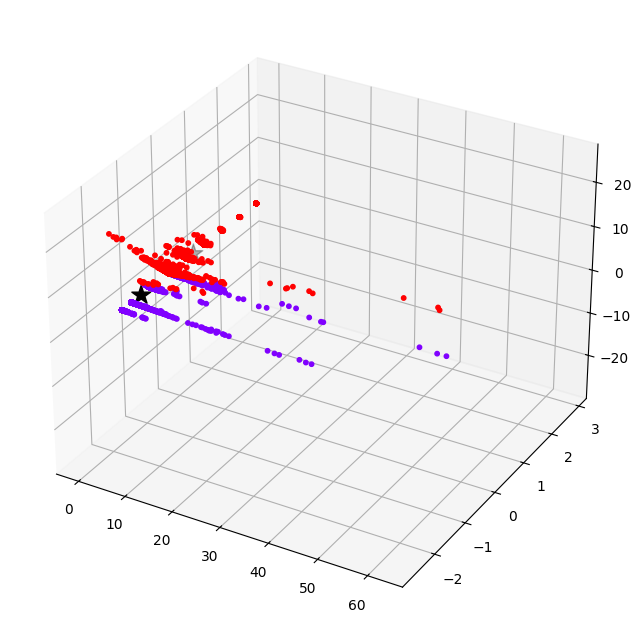

In [19]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# 데이터 scatterplot
ax.scatter(X_ff.iloc[:,0], X_ff.iloc[:,1], X_ff.iloc[:,2], c = y_cluster_kmeans, s = 10, cmap = "rainbow", alpha = 1)

# centroid scatterplot
ax.scatter(centers[:,0], centers[:,1] , c = 'black', s = 200, marker = '*')

'성별', '연령별', '직업구분', '최근12개월신용및체크카드이용금액합계', '최근12개월전체체크카드이용금액합계', '최근12개월해외이용금액합계' 6개의 칼럼을       
Facotr1(주로 이용금액합계와 관계있는), Factor2(주로 연령별과 관계있는), Factor3 3개의 변수로 압축한 데이터를 통한 클러스터링 결과입니다.     
3d 산점도를 통해 별로된 2개의 클러스터의 중심점과 빨강색, 보라색 점을 통하여 결과를 볼 수 있습니다. 
 

*결론        
결국 k-means 알고리즘으로 클러스터링을 하면 이용금액대가 높은 집단과 낮은 집단 두 집단으로 나누어집니다.       
클러스터링을 통해 특별히 의미있는 다른 집단을 찾을 수가 없었습니다.       

이용금액이 단위가 매우 커 이런 결과가 나오는 것 같아 정규화를 진행하면 의미있는 클러스터링이 이루어 지지 않았습니다.       
처음부터 클러스터링에 적합한 데이터 셋을 찾는 것에 실패한 것 같습니다.           
데이터 셋 선택에 많은 시간을 들였지만 교수님이 말씀하신대로 적합한 데이터를 찾는 것이 제일 어려운 것 같습니다.        
